In [1]:
%matplotlib inline

from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from numpy import asarray

import imutils
import numpy as np
import argparse
import cv2
import glob
import scipy
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import imageio
import os


Using TensorFlow backend.


In [2]:
# To avoid an operating system issue
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Basic CNN
- Train a basic CNN for skin type classifiction
- reference:
    - https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c
    - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- rmb data in ../data/recommendation/train  ../data/recommendation/validation
    - then each in subfolder: oily/, normal/, and dry/
    - 70:30

### Create generator to perform data augmentation 
- To enchance the amount of data for training

In [ ]:
train_dir = '../data/recommendation/train'
val_dir = '../data/recommendation/validation'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# validation generator; no need for augmentation
val_datagen = ImageDataGenerator(rescale = 1./255)

# Define the datasets
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode='categorical')
val_set = val_datagen.flow_from_directory(val_dir,
                                            target_size=(64, 64),
                                            batch_size=32,
                                            class_mode='categorical')


In [4]:
# check the classes
training_set.class_indices

{'dry': 0, 'normal': 1, 'oily': 2}

## Define and train a basic CNN model
- Follow MNIST convnet: https://keras.io/examples/vision/mnist_convnet/

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import tensorflow as tf
import os
import random

# https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
# for reproducible results
tf.random.set_seed(10)
np.random.seed(10) 
random.seed(10)
os.environ['PYTHONHASHSEED']=str(10)

In [18]:
# Parameters
num_classes = 3
input_shape = (64,64,3)

# Define the model
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [19]:
# Define the model check point to keep track of model performance
cb_checkpointer = ModelCheckpoint(filepath="../models/checkpoint/basic_cnn_epoch{epoch:02d}-val_acc{val_accuracy:.2f}.h5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True,
                               mode='max'
                              )

# Define the early-stopping callback to stop the model training when there is no improvement on the model
# Stop after no improvement in consective 5 epochs
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
cb_earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)


In [9]:
# Configure the model
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], optimizer = 'adam')

nb_epochs = 30

# fit_generator will be depreciated, so can use fit() directly
hist = model.fit(training_set,
                  epochs=nb_epochs,
                  callbacks = [cb_checkpointer, cb_earlystop],
                  validation_data=val_set,
                  workers=4)


AttributeError: 'ModelCheckpoint' object has no attribute '_implements_train_batch_hooks'

## Test the trained model

In [21]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [25]:
# load the trained model
model = tf.keras.models.load_model('../models/checkpoint/basic_cnn_epoch15-val_acc0.76.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

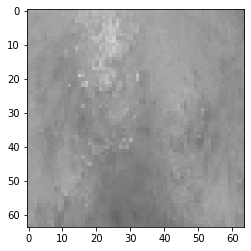

(1, 64, 64, 3)


In [26]:
# load a test image
img_path = '../data2/recommendation/test/greyo0032_oily_B07D5GQ7RD_pid249_0.jpg'
img = load_img(img_path, target_size=(64, 64))

# convert the image to suitable format
img = img_to_array(img)
img /= 255.
img = np.expand_dims(img, axis=0)

# show
plt.imshow(img[0])
plt.show()
print(img.shape)

In [28]:
# prediction
pred = model.predict(img)[0]
pos = np.argmax(pred)

# preidction probability
classes = training_set.class_indices
for c in classes.keys():
    print('The probabiliy of this image being class %s:%s' %(c, pred[classes[c]]))

# return predicted label
for c in classes.keys():
    if classes[c] == pos:
        print('The predicted class is therefore:', c)


The probabiliy of this image being class dry:0.3964573
The probabiliy of this image being class normal:0.09498733
The probabiliy of this image being class oily:0.50855535
The predicted class is therefore: oily


# Using Pretrain Models - ResNet50, DenseNet121, etc
- Using pretrain models in Keras model zoo to see the classification performance
- reference
    - https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29
    - https://stackoverflow.com/questions/43027764/training-a-model-using-a-pre-trained-model


## Load the data

In [7]:
train_dir = '../data/old/train'
val_dir = '../data/old/validate'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# validation generator; no need for augmentation
val_datagen = ImageDataGenerator(rescale = 1./255)

# Define the datasets
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(112, 112),
                                                 batch_size=32,
                                                 class_mode='categorical')
val_set = val_datagen.flow_from_directory(val_dir,
                                            target_size=(112, 112),
                                            batch_size=32,
                                            class_mode='categorical')



Found 515 images belonging to 3 classes.
Found 222 images belonging to 3 classes.


In [30]:
# check the classes
training_set.class_indices

{'dry': 0, 'normal': 1, 'oily': 2}

## Construct and train the model

- We will load certain pretrain model and then freeze their weights (meaning don't need to train them). We will attach pretrain model to the custom layers and learn weights of the cutom layers.
- pretrain models: (https://keras.io/api/applications/)
    - ResNet50
    - EfficientNetB0
    - etc

In [43]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121
import keras
import numpy as np
import tensorflow as tf
import os
import random

tf.random.set_seed(10)
np.random.seed(10) 
random.seed(10)
os.environ['PYTHONHASHSEED']=str(10)


In [54]:
# Parameters
num_classes = 3
input_shape = (112,112,3)
model_type = 'desnet'


# Configure the pretrain model
# freeze all the layers so don't train them again during training
if model_type == 'resnet':
    model_pretrain = ResNet50(weights='imagenet', 
                              include_top=False, 
                              input_shape=input_shape,
                              # pooling='avg', # global pooling at the last layer 
                                            # to reduce the size of the traininable weights
                             )
elif model_type == 'densenet':
    model_pretrain = DenseNet121(weights='imagenet', 
                              include_top=False, 
                              input_shape=input_shape,
                              #pooling='avg', # global pooling at the last layer
                                            # to reduce the size of the traininable weights
                             )  
    
model_pretrain.trainable = False

# Define a new model based on the pretrained model
model = keras.Sequential([
    model_pretrain,
    keras.layers.Flatten(),
    keras.layers.Dense(64),
    keras.layers.Dense(num_classes, activation="softmax"),
    ])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2097216   
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 195       
Total params: 25,685,123
Trainable params: 2,097,411
Non-trainable params: 23,587,712
_________________________________________________________________


In [55]:
# Define the model check point to keep track of model performance
cb_checkpointer = ModelCheckpoint(filepath="../models/checkpoint/%s_cnn_epoch{epoch:02d}-val_acc{val_accuracy:.2f}.h5" %(model_type), 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True,
                               mode='max'
                              )

# Define the early-stopping callback to stop the model training when there is no improvement on the model
# Stop after no improvement in consective 5 epochs
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
cb_earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)


In [ ]:
# Configure the model #DENSENET
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], optimizer = 'adam')

nb_epochs = 30


# fit_generator will be depreciated, so can use fit() directly
hist = model.fit(training_set,
                  epochs=nb_epochs,
                  callbacks = [cb_checkpointer, cb_earlystop],
                  validation_data=val_set,
                  workers=4)


## Test the trained model

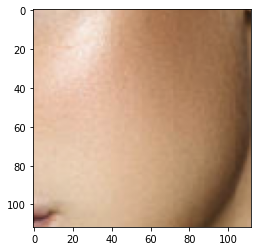

(1, 112, 112, 3)


In [63]:
# load a test image
img_path = '../data/test/normal970.jpg'
img = load_img(img_path, target_size=(112, 112))

# convert the image to suitable format
img = img_to_array(img)
img /= 255.
img = np.expand_dims(img, axis=0)

# show
plt.imshow(img[0])
plt.show()
print(img.shape)

In [64]:
# prediction
pred = model.predict(img)[0]
pos = np.argmax(pred)

# preidction probability
classes = training_set.class_indices
for c in classes.keys():
    print('The probabiliy of this image being class %s:%s' %(c, pred[classes[c]]))

# return predicted label
for c in classes.keys():
    if classes[c] == pos:
        print('The predicted class is therefore:', c)


The probabiliy of this image being class dry:3.9601033e-05
The probabiliy of this image being class normal:0.9999604
The probabiliy of this image being class oily:1.6966394e-10
The predicted class is therefore: normal


In [65]:
# Parameters
num_classes = 3
input_shape = (112,112,3)
model_type = 'resnet'  


# ============================== Configure the pretrain model
# Make sure we freeze all the layers so that we won't train them again during train
if model_type == 'resnet':
    model_pretrain = ResNet50(weights='imagenet', 
                              include_top=False, 
                              input_shape=input_shape,
                              # pooling='avg', # global pooling at the last layer
                                            # to reduce the size of the traininable weights
                             )
elif model_type == 'densenet':
    model_pretrain = DenseNet121(weights='imagenet', 
                              include_top=False, 
                              input_shape=input_shape,
                              #pooling='avg', # global pooling at the last layer
                                            # to reduce the size of the traininable weights
                             )  
    
model_pretrain.trainable = False

# ============================== Define a new model based on the pretrained model
model = keras.Sequential([
    model_pretrain,
    keras.layers.Flatten(),
    keras.layers.Dense(64),
    keras.layers.Dense(num_classes, activation="softmax"),
    ])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2097216   
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 195       
Total params: 25,685,123
Trainable params: 2,097,411
Non-trainable params: 23,587,712
_________________________________________________________________
